In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import fnmatch
import os
import SimpleITK as sitk
from matplotlib.patches import Rectangle

# ANNOTATIONS

The annotation file is a csv file that contains one finding per line. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. The annotation file contains 1186 nodules.

The list of annotations that are not used as reference standard will be provided. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. It has to be noted that findings that were annotated as nodule < 3 mm and non-nodule have no diameter measurement.

In [2]:
annotations = pd.read_csv("/home/msmith/luna16/CSVFILES/annotationFullPaths.csv")
print(annotations.shape)
annotations.head()

(1186, 6)


,seriesuid,coordX,coordY,coordZ,diameter_mm,serisuidComplete
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/home/msmith/luna16/subset5/1.3.6.1.4.1.14519....
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....


In [3]:
# Some Functions
def getPathSeriesuid(seriesuid):
    pattern = '*'+seriesuid+'*'
    for roots, dirs, files in os.walk('/home/msmith/luna16/'):
            for filename in fnmatch.filter(files,pattern):
                returnPath = os.path.join(roots,filename)
                #print(returnPath)
    return returnPath

def getAnnotationsFullPathCSV():
    # Includes full path of files in final column
    annotations["serisuidComplete"] = annotations["seriesuid"].apply(getPathSeriesuid) # Get complete paths of files (takes a while)
    annotations.to_csv("/CSVFILES/annotationsFullPaths.csv",index=0)

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def load_originSpacing(filename):
    itkimage = sitk.ReadImage(filename)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyOrigin, numpySpacing

'''
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(itkimage.GetOrigin()))
    numpySpacing = np.array(list(itkimage.GetSpacing()))
    return numpyImage, numpyOrigin, numpySpacing
'''

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord
#ofInterest = annotations[annotations["seriesuid"].str.contains("1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228")]

In [4]:
def getImageNVC(obs,data):
    data = data.iloc[obs]
    noduleCoords = data['coordX'],data['coordY'],data['coordZ']
    mhdPath = data.serisuidComplete.replace(".raw",".mhd")
    imgOrigin, imgSpacing = load_originSpacing(mhdPath)

    nvc = worldToVoxelCoord(noduleCoords[::-1],imgOrigin,imgSpacing)
    nvc = np.array(nvc.astype(int))
    return nvc


In [5]:
# Append Vox coords to dataframe
def makeAnnotationsCSVnodules(data,name):
    data['vxX'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
    data['vxY'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
    data['vxZ'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
    for obs in xrange(data.shape[0]):
        #print(annotations.shape[0])
        if obs % 100 ==0:
            print(obs)
        nvc = getImageNVC(obs)

        data.set_value(obs, 'vxX', nvc[2])
        data.set_value(obs, 'vxY', nvc[1])
        data.set_value(obs, 'vxZ', nvc[0])
    data.to_csv("/home/msmith/luna16/CSVFILES/"+name+"NVC.csv",index=0) # just NVC

('Using observation', 1004)
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557...
coordX                                                  48.68312
coordY                                                 -15.35627
coordZ                                                 -80.56923
diameter_mm                                             22.78153
Name: 1004, dtype: object
ObjectType = Image
NDims = 3
BinaryData = True
BinaryDataByteOrderMSB = False
CompressedData = False
TransformMatrix = 1 0 0 0 1 0 0 0 1
Offset = -186.89999399999999 -190 -375.75
CenterOfRotation = 0 0 0
AnatomicalOrientation = RAI
ElementSpacing = 0.7421879768371582 0.7421879768371582 2.5
DimSize = 512 512 137
ElementType = MET_SHORT
ElementDataFile = 1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.raw



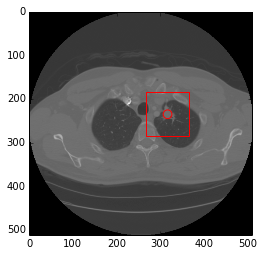

116


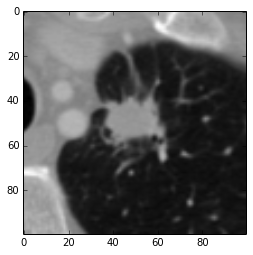

117


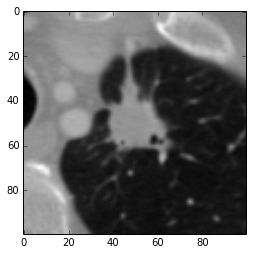

Nodule located here
118


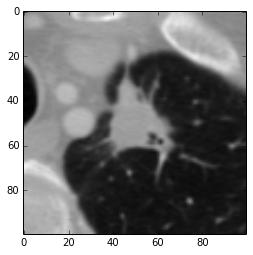

119


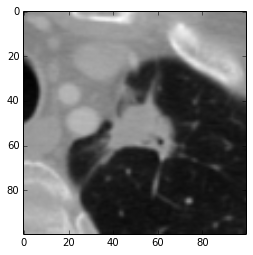

In [17]:
# Get random annotation from list
randInt = np.random.randint(annotations.shape[0])
#randInt = 1
annotationsOld = pd.read_csv("/home/msmith/luna16/CSVFILES/annotations.csv")
randAnnotation = annotationsOld.iloc[randInt]

noduleCoords = randAnnotation['coordX'],randAnnotation['coordY'],randAnnotation['coordZ']
pattern = '*'+randAnnotation['seriesuid']+'*'

imgPath = getPathSeriesuid(pattern)
rawPath = imgPath[:-3] + 'raw'
img = np.fromfile(rawPath,dtype='int16')
with open(imgPath[:-3] + 'mhd',"r") as f:
    imgData = f.read()
    mhdPath = rawPath[:-3] + 'mhd'
    
img, imgOrigin, imgSpacing = load_itk_image(mhdPath)

def printInfo():
    print("Using observation", randInt)
    print(randAnnotation)
    print("=="*50)
    print("=="*50)
    print(imgData)
    annotationsOld[randInt:randInt+1]
printInfo()

# Nodule voxel coordinates (nvc)
nvc = worldToVoxelCoord(noduleCoords[::-1],imgOrigin,imgSpacing)
nvc = np.array(nvc.astype(int))

#Get a range in which to subset the data
margin = 50
nvcMinus,nvcPlus = (nvc - margin).astype(int), (nvc + margin).astype(int)
def printNoduleInfo():
    print("Image shape ==>" + "\n" + str(img.shape))
    print("Nodule coordinates @"+"\n" + str(nvc))
    print("NVC margins ==>" + "\n" + str(nvcMinus) + "\n" + str(nvcPlus))
#printNoduleInfo()

from matplotlib.patches import Rectangle
rectangle = plt.Rectangle((nvcMinus[2], nvcMinus[1]),margin*2 ,margin*2, facecolor = 'none', ec='r')
circle = plt.Circle((nvc[2],nvc[1]),10, facecolor = 'none', ec='r')
plt.gca().add_patch(rectangle)
plt.gca().add_patch(circle)
plt.imshow(img[nvc[0]],cmap=cm.gray)
plt.show()

for i in xrange(nvc[0]-2,nvc[0]+2,1):
    if i == nvc[0]:
        print("Nodule located here")
    print(i)
    plt.imshow(img[i,nvcMinus[1]:nvcPlus[1],nvcMinus[2]:nvcPlus[2]],cmap=cm.gray)
    plt.show()


## Nodule Cut Outs

Here we extract all the nodules in a 64^3 cube to find features 

In [ ]:
annotationsNVC = pd.read_csv("/home/msmith/luna16/CSVFILES/annotationsNVC.csv")
annotationsNVC.head(5)

In [ ]:
margin = 16 # cube will be margin^3 in size
allNodules = np.empty([1,margin*2,margin*2,margin*2]) # Array to append images to
data = annotationsNVC
total = data.shape[0]
for i in xrange(total):
    annotation = data.ix[i]
    mhdPath = annotation.serisuidComplete.replace(".raw",".mhd")
    img = sitk.ReadImage(mhdPath)
    imgArray = sitk.GetArrayFromImage(img)
    x,y,z = int(annotation.vxX), int(annotation.vxY), int(annotation.vxZ)
    add = lambda x, add: x + add
    imgNodule = imgArray[add(z,-margin):add(z,margin),add(y,-margin):add(y,margin),add(x,-margin):add(x,margin)]
    try:
        imgNodule = imgNodule.reshape(1,margin*2,margin*2,margin*2)
        allNodules = np.append(allNodules,imgNodule,axis=0)
        if i % 50 == 0:

            print(i, " out of ", total)
            plt.subplot(131)
            plt.imshow(allNodules[i-1,margin],cmap=cm.gray)

            plt.subplot(132)
            plt.imshow(allNodules[i-1,:,margin],cmap=cm.gray)
            plt.subplot(133)
            plt.imshow(allNodules[i-1,:,:,margin],cmap=cm.gray)

            plt.title("Diameter " + str(annotation.diameter_mm))
            plt.show()
    except ValueError:
        print("Nodule is locted near egde for observation ",i)
        continue

In [ ]:
#np.save("/home/msmith/luna16/CSVFILES/annotationsCrop"+str(margin)+".npy",allNodules)
allNodules = np.load("/home/msmith/luna16/annotationsCrop"+str(margin)+".npy")

In [ ]:
allNodules = allNodules[~np.isnan(allNodules)]
allNodules > 100

In [ ]:
flattened = allNodules.flatten()

In [ ]:
np.percentile(allNodules,[5,95])

In [ ]:
plt.hist(flattened,range=[-2000, 2000])
plt.show()

# CANDIDATES

The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordinates, and the corresponding class. The list of candidates is provided for participants who are following the ‘false positive reduction’ track. Tutorial on how to view lesions given the location of candidates will be available on the Forum page.

The candidate locations are computed using three existing candidate detection algorithms [1-3]. As lesions can be detected by multiple candidates, those that are located <= 5 mm are merged. Using this method, 1120 out of 1186 nodules are detected with 551,065 false positives. For convenience, the corresponding class label (0 for non-nodule and 1 for nodule) for each candidate is provided in the list. It has to be noted that there can be multiple candidates per nodule.

In [ ]:
candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidates.csv")
# Includes full path of files in final column
candidates["serisuidComplete"] = candidates["seriesuid"].apply(getPathSeriesuid) # Get complete paths of files (takes a while)
candidates.to_csv("/CSVFILES/candidatesFullPaths.csv",index=0)

#getCandidatesFullPathCSV()


In [ ]:
# Append Vox coords to dataframe
def makeAnnotationsCSVnodules(data,name):
    data['vxX'] = pd.Series(np.zeros(data.shape[0]), index=data.index)
    data['vxY'] = pd.Series(np.zeros(data.shape[0]), index=data.index)
    data['vxZ'] = pd.Series(np.zeros(data.shape[0]), index=data.index)
    for obs in xrange(data.shape[0]):
        #print(annotations.shape[0])
        if obs % 100 ==0:
            print(obs)
        nvc = getImageNVC(obs,data)

        data.set_value(obs, 'vxX', nvc[2])
        data.set_value(obs, 'vxY', nvc[1])
        data.set_value(obs, 'vxZ', nvc[0])
    data.to_csv("/home/msmith/luna16/CSVFILES/"+name+"NVC.csv",index=0) # just NVC

In [ ]:
makeAnnotationsCSVnodules(candidates,"candidates")